# Aging Aware with Model Variation
Previously, we optimize the following functional:
$$ \min_\theta \, \int_{t=0}^{1} \; L(\theta(t)) \, {\rm d}t. $$
The optimum is for a specific aging model $\omega$, i.e., we minimized the 
$$ \min_\theta \, \int_{t=0}^{1} \; L(\theta(t,\omega)) \, {\rm d}t. $$
However, we dont know how will the resistance decay, i.e., we should also minimize the loss function w.r.t. aging models with different parameters. That means we need to optimized
$$ \min_\theta \, \int_{\omega}\int_{t=0}^{1} \; L(\theta(t,\omega)) \, {\rm d}t\, p(\omega){\rm d}\omega. $$
The Mento Carlo Approximation is then
$$
\min_{\theta_{\rm init}} \frac{1}{\Omega}\frac{1}{K}\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} } L \left(\theta[k, \omega]\right),
$$
where $\mathfrak{M}$ is the set of $\Omega$ elements following the distribution $p(\omega)$. $p(\omega)$ is the distributions of parameters of the aging model. We have already obtained these distributions as we modeled the aging decay.

That means we should optimize this problem by
$$
\begin{align}
\theta_{\rm init}&:=\theta_{\rm init} - \alpha\cdot\nabla_{\theta_{\rm init}}\left(\frac{1}{\Omega}\frac{1}{K}\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} } L \left(\theta[k, \omega]\right)\right)\\
&=\theta_{\rm init} - \frac{\alpha}{\Omega K}\cdot\nabla_{\theta_{\rm init}}\left(\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} } L \left(\theta[k, \omega]\right)\right)\\
&=\theta_{\rm init} - \frac{\alpha}{\Omega K}\left(\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} }\nabla_{\theta_{\rm init}} L \left(\theta[k, \omega]\right)\right)
\end{align}
$$

# Get aging model

In [1]:
import importlib
from torch.autograd import Variable
import torch
import pickle
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pNN_aging_aware_vectorization as pnnv
import training_vectorization as tv
sys.path.append(os.path.join(os.getcwd(), 'Aging_Model'))

with open(os.path.join(os.getcwd(), 'Aging_Model', 'exp_aging_model.p'), 'rb') as f:
    age_generator = pickle.load(f)

# Device

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Prepare data

## Dataset

In [3]:
ds = 'Pendigits'

## Load data

In [4]:
datapath = os.path.join(os.getcwd(), 'Datasets', 'Haibin',
                        'data_processed', f'Dataset_{ds}.p')
with open(datapath, 'rb') as f:
    dataset = pickle.load(f)
X = dataset['X'].float()
y = dataset['y']

E, N_features, N_class = X.shape[0], X.shape[1], torch.max(
    torch.unique(y)).item()+1
X.shape, y.shape, E, N_features, N_class

(torch.Size([10992, 16]), torch.Size([10992]), 10992, 16, 10)

## data preprocessing

In [5]:
# normalization
X = X / (torch.max(X, axis=0)[0] - torch.min(X, axis=0)[0])
X = X - torch.min(X, axis=0)[0]
torch.min(X), torch.max(X)

(tensor(0.), tensor(1.))

In [6]:
X[:10, :9]

tensor([[0.4700, 1.0000, 0.2700, 0.8100, 0.5700, 0.3700, 0.2600, 0.0000, 0.0000],
        [0.0000, 0.8900, 0.2700, 1.0000, 0.4200, 0.7500, 0.2900, 0.4500, 0.1500],
        [0.0000, 0.5700, 0.3100, 0.6800, 0.7200, 0.9000, 1.0000, 1.0000, 0.7600],
        [0.0000, 1.0000, 0.0700, 0.9200, 0.0500, 0.6800, 0.1900, 0.4500, 0.8600],
        [0.0000, 0.6700, 0.4900, 0.8300, 1.0000, 1.0000, 0.8100, 0.8000, 0.6000],
        [1.0000, 1.0000, 0.8800, 0.9900, 0.4900, 0.7400, 0.1700, 0.4700, 0.0000],
        [0.0000, 1.0000, 0.0300, 0.7200, 0.2600, 0.3500, 0.8500, 0.3500, 1.0000],
        [0.0000, 0.3900, 0.0200, 0.6200, 0.1100, 0.0500, 0.6300, 0.0000, 1.0000],
        [0.1300, 0.8900, 0.1200, 0.5000, 0.7200, 0.3800, 0.5600, 0.0000, 0.0400],
        [0.5700, 1.0000, 0.2200, 0.7200, 0.0000, 0.3100, 0.2500, 0.0000, 0.7500]])

In [7]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

# generate tensordataset
dataset = TensorDataset(X.to(device), y.to(device))

# split
train_rate = 0.6
test_rate = 0.2
valid_rate = 0.2
E_train = min(8192, int(E*train_rate))
E_test = min(2048, int(E*test_rate))
E_valid = min(2048, int(E*valid_rate))

train_data, rest_data = random_split(
    dataset, [E_train, E-E_train], generator=torch.Generator().manual_seed(19950102))
test_data, rest_data = random_split(rest_data, [
                                     E_test, E-E_train-E_test], generator=torch.Generator().manual_seed(19950102))
valid_data, rest_data = random_split(rest_data, [
                                     E_valid, E-E_train-E_test-E_valid], generator=torch.Generator().manual_seed(19950102))

len(train_data), len(test_data), len(valid_data)

(6595, 2048, 2048)

In [8]:
# batch
train_loader = DataLoader(train_data, batch_size=len(train_data))
test_loader = DataLoader(test_data, batch_size=len(test_data))
valid_loader = DataLoader(valid_data, batch_size=len(valid_data))

# Hyperparameter

In [9]:
N_Hidden = 10
m = 0.3
T = 0.1
M = 50
K = 10
M_train = 200
K_train = 20
M_test = 20
K_test = 10
M_valid = 500
K_valid = 50

# Normal NN

## Define

In [10]:
NN = torch.nn.Sequential(torch.nn.Linear(N_features, N_Hidden), torch.nn.Tanh(),
                        torch.nn.Linear(N_Hidden, N_class), torch.nn.Tanh())


def weights_init(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

NN.apply(weights_init)

celoss = torch.nn.CrossEntropyLoss()
NN.to(device)

Sequential(
  (0): Linear(in_features=16, out_features=10, bias=True)
  (1): Tanh()
  (2): Linear(in_features=10, out_features=10, bias=True)
  (3): Tanh()
)

## Training

In [11]:
optimizer_NN = torch.optim.Adam(NN.parameters(), lr=0.001)
train_loader = DataLoader(train_data, batch_size=min(len(train_data),1024))
train_loss_NN, test_loss_NN, parameter_NN = tv.train_normal_nn(NN,
                                                                     train_loader,
                                                                     test_loader,
                                                                     optimizer=optimizer_NN,
                                                                     lossfunction=celoss,
                                                                     Epoch=15000)

  0%|          | 0/15000 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.10547 | Loss: 2.438435793 |
| Epoch:   200 | Accuracy: 0.86621 | Loss: 1.135542512 |
| Epoch:   400 | Accuracy: 0.91211 | Loss: 0.986372650 |
| Epoch:   600 | Accuracy: 0.93750 | Loss: 0.928848207 |
| Epoch:   800 | Accuracy: 0.95020 | Loss: 0.901226938 |
| Epoch:  1000 | Accuracy: 0.95947 | Loss: 0.887156606 |
| Epoch:  1200 | Accuracy: 0.96045 | Loss: 0.880410492 |
| Epoch:  1400 | Accuracy: 0.96045 | Loss: 0.876848817 |
| Epoch:  1600 | Accuracy: 0.96094 | Loss: 0.874322772 |
| Epoch:  1800 | Accuracy: 0.96045 | Loss: 0.872536659 |
| Epoch:  2000 | Accuracy: 0.96240 | Loss: 0.871174991 |
| Epoch:  2200 | Accuracy: 0.96436 | Loss: 0.869707525 |
| Epoch:  2400 | Accuracy: 0.96729 | Loss: 0.866807878 |
| Epoch:  2600 | Accuracy: 0.96973 | Loss: 0.865246594 |
| Epoch:  2800 | Accuracy: 0.96973 | Loss: 0.864253402 |
| Epoch:  3000 | Accuracy: 0.96973 | Loss: 0.863499105 |
| Epoch:  3200 | Accuracy: 0.96973 | Loss: 0.862620950 |
| Epoch:  3400 | Accuracy: 0.96

(13550, tensor(0.8536))

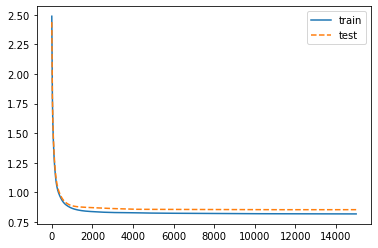

In [12]:
plt.plot(train_loss_NN, '-', label='train')
plt.plot(test_loss_NN, '--', label='test')
plt.legend()
NN.load_state_dict(parameter_NN)
best = np.argmin(test_loss_NN)
best, test_loss_NN[best]

In [13]:
optimizer_NN = torch.optim.Adam(NN.parameters(), lr=0.001)
train_loader = DataLoader(train_data, batch_size=len(train_data))
train_loss_NN, test_loss_NN, parameter_NN = tv.train_normal_nn(NN,
                                                                     train_loader,
                                                                     test_loader,
                                                                     optimizer=optimizer_NN,
                                                                     lossfunction=celoss,
                                                                     Epoch=5000)

  0%|          | 0/5000 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.97168 | Loss: 0.853738129 |
| Epoch:   200 | Accuracy: 0.97070 | Loss: 0.853904545 |
| Epoch:   400 | Accuracy: 0.97070 | Loss: 0.854244053 |
| Epoch:   600 | Accuracy: 0.97021 | Loss: 0.854533911 |
| Epoch:   800 | Accuracy: 0.97021 | Loss: 0.854765832 |
| Epoch:  1000 | Accuracy: 0.97070 | Loss: 0.854861796 |
| Epoch:  1200 | Accuracy: 0.97119 | Loss: 0.854615629 |
| Epoch:  1400 | Accuracy: 0.97217 | Loss: 0.854576588 |
| Epoch:  1600 | Accuracy: 0.97266 | Loss: 0.855084300 |
| Epoch:  1800 | Accuracy: 0.97266 | Loss: 0.854940116 |
| Epoch:  2000 | Accuracy: 0.97314 | Loss: 0.854386747 |
| Epoch:  2200 | Accuracy: 0.97412 | Loss: 0.854566455 |
| Epoch:  2400 | Accuracy: 0.97412 | Loss: 0.854575336 |
| Epoch:  2600 | Accuracy: 0.97363 | Loss: 0.854495347 |
| Epoch:  2800 | Accuracy: 0.97363 | Loss: 0.853845179 |
| Epoch:  3000 | Accuracy: 0.97412 | Loss: 0.853542805 |
| Epoch:  3200 | Accuracy: 0.97363 | Loss: 0.853305459 |
| Epoch:  3400 | Accuracy: 0.97

(4401, tensor(0.8524))

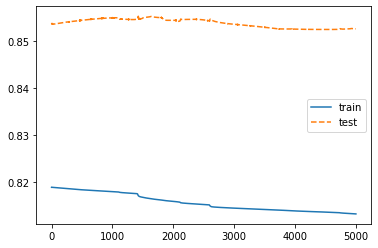

In [14]:
plt.plot(train_loss_NN, '-', label='train')
plt.plot(test_loss_NN, '--', label='test')
plt.legend()
NN.load_state_dict(parameter_NN)
best = np.argmin(test_loss_NN)
best, test_loss_NN[best]

## Save Model

In [15]:
with open(f'./result/{ds}_NN.p', 'wb') as f:
    pickle.dump(NN, f)

## Evaluation

In [16]:
for x_valid, y_valid in valid_loader:
    prediction_valid = NN(x_valid)
    p = torch.argmax(prediction_valid, 1)
    pred_y = p.cpu().data.numpy().squeeze()
    acc_valid = sum(pred_y == y_valid.cpu().numpy()) / y_valid.shape[0]
print(acc_valid)

0.9794921875


# Normal PNN

## Define

In [25]:
PNN = torch.nn.Sequential(pnnv.PNNLayer(N_features, N_Hidden, age_generator, xpu=device),
                         pnnv.PNNLayer(N_Hidden, N_class, age_generator, xpu=device))

PNN.apply(lambda z: pnnv.MakeModel(z, M=1))
PNN.apply(lambda z: pnnv.SetTime(z, t=[0]))

PNN.to(device)

Sequential(
  (0): PNNLayer()
  (1): PNNLayer()
)

## Training

In [ ]:
optimizer_PNN = torch.optim.Adam(PNN.parameters(), lr=0.01)
train_loader = DataLoader(train_data, batch_size=min(len(train_data),1024))
train_loss_PNN, test_loss_PNN, parameter_PNN = tv.train_normal_pnn(PNN, train_loader, test_loader,
                                                                   m, T, optimizer_PNN,
                                                                   pnnv.LossFunction, Epoch=50000, cache=ds)

  0%|          | 0/50000 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.09521 | Loss: 1.372618198 |
| Epoch:   200 | Accuracy: 0.90576 | Loss: 0.182976678 |
| Epoch:   400 | Accuracy: 0.92578 | Loss: 0.152072877 |
| Epoch:   600 | Accuracy: 0.93604 | Loss: 0.143025905 |
| Epoch:   800 | Accuracy: 0.93652 | Loss: 0.138509542 |
| Epoch:  1000 | Accuracy: 0.93750 | Loss: 0.134686619 |
| Epoch:  1200 | Accuracy: 0.94092 | Loss: 0.130581021 |
| Epoch:  1400 | Accuracy: 0.94141 | Loss: 0.127349764 |
| Epoch:  1600 | Accuracy: 0.94141 | Loss: 0.126616806 |
| Epoch:  1800 | Accuracy: 0.94238 | Loss: 0.126666263 |
| Epoch:  2000 | Accuracy: 0.94141 | Loss: 0.126404434 |
| Epoch:  2200 | Accuracy: 0.94141 | Loss: 0.126712605 |
| Epoch:  2400 | Accuracy: 0.94092 | Loss: 0.126431853 |
| Epoch:  2600 | Accuracy: 0.94043 | Loss: 0.126740858 |
| Epoch:  2800 | Accuracy: 0.94141 | Loss: 0.126512825 |
| Epoch:  3000 | Accuracy: 0.94092 | Loss: 0.126819372 |
| Epoch:  3200 | Accuracy: 0.94043 | Loss: 0.126532689 |
| Epoch:  3400 | Accuracy: 0.94

In [ ]:
plt.plot(train_loss_PNN, '-', label='train')
plt.plot(test_loss_PNN, '--', label='test')
plt.legend()
best = np.argmin(test_loss_PNN)
PNN.load_state_dict(parameter_PNN)
best, test_loss_PNN[best]

In [15]:
optimizer_PNN = torch.optim.Adam(PNN.parameters(), lr=0.001)
train_loader = DataLoader(train_data, batch_size=len(train_data))
train_loss_PNN, test_loss_PNN, parameter_PNN = tv.train_normal_pnn(PNN, train_loader, test_loader,
                                                                   m, T, optimizer_PNN,
                                                                   pnnv.LossFunction, Epoch=50000, cache=ds)

  0%|          | 0/50000 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.94434 | Loss: 0.122873396 |
| Epoch:   200 | Accuracy: 0.94434 | Loss: 0.122609466 |
| Epoch:   400 | Accuracy: 0.94434 | Loss: 0.122625157 |
| Epoch:   600 | Accuracy: 0.94434 | Loss: 0.122624978 |
| Epoch:   800 | Accuracy: 0.94434 | Loss: 0.122623511 |
| Epoch:  1000 | Accuracy: 0.94434 | Loss: 0.122648954 |
| Epoch:  1200 | Accuracy: 0.94434 | Loss: 0.122633427 |
| Epoch:  1400 | Accuracy: 0.94434 | Loss: 0.122643873 |
| Epoch:  1600 | Accuracy: 0.94434 | Loss: 0.122631289 |
| Epoch:  1800 | Accuracy: 0.94434 | Loss: 0.122638404 |
| Epoch:  2000 | Accuracy: 0.94434 | Loss: 0.122640669 |
| Epoch:  2200 | Accuracy: 0.94434 | Loss: 0.122652918 |
| Epoch:  2400 | Accuracy: 0.94434 | Loss: 0.122635655 |
| Epoch:  2600 | Accuracy: 0.94385 | Loss: 0.122636639 |
| Epoch:  2800 | Accuracy: 0.94385 | Loss: 0.122630686 |
| Epoch:  3000 | Accuracy: 0.94385 | Loss: 0.122641176 |
| Epoch:  3200 | Accuracy: 0.94385 | Loss: 0.122609861 |
| Epoch:  3400 | Accuracy: 0.94

(5, tensor(0.1225))

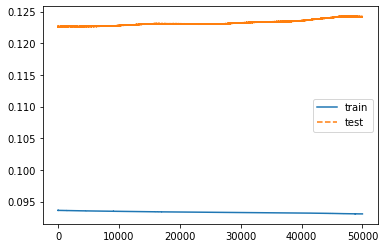

In [16]:
plt.plot(train_loss_PNN, '-', label='train')
plt.plot(test_loss_PNN, '--', label='test')
plt.legend()
best = np.argmin(test_loss_PNN)
PNN.load_state_dict(parameter_PNN)
best, test_loss_PNN[best]

## Save Model

In [17]:
with open(f'./result/{ds}_PNN.p', 'wb') as f:
    pickle.dump(PNN, f)

# Aging Aware PNN

In [25]:
AAPNN = torch.nn.Sequential(pnnv.PNNLayer(N_features, N_Hidden, age_generator, xpu=device),
                           pnnv.PNNLayer(N_Hidden, N_class, age_generator, xpu=device))

AAPNN.apply(lambda z: pnnv.MakeModel(z, M))
AAPNN.apply(lambda z: pnnv.SetTime(z, np.random.rand(K).tolist()))

AAPNN.to(device)

Sequential(
  (0): PNNLayer()
  (1): PNNLayer()
)

## Reload AAPNN if crash

In [10]:
if os.path.exists(f'./temp/{ds}_AAPNN.p'): 
    with open(f'./temp/{ds}_AAPNN.p', 'rb') as f:
        AAPNN = pickle.load(f)

In [11]:
AAPNN[0].theta_.shape

torch.Size([10, 18])

## Training

In [12]:
optimizer_AAPNN = torch.optim.Adam(AAPNN.parameters(), lr=0.1)
train_loader = DataLoader(train_data, batch_size=min(len(train_data),1024))
train_loss_AAPNN, test_loss_AAPNN, parameter_AAPNN = tv.train_aged_pnn(AAPNN, train_loader, test_loader,
                                        m, T, M, K, M_test, K_test,
                                        optimizer_AAPNN, pnnv.LossFunction,
                                        Epoch=100, cache=ds)

  0%|          | 0/100 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.89410 | Loss: 0.203343496 |
| Epoch:    10 | Accuracy: 0.90017 | Loss: 0.187011003 |
| Epoch:    20 | Accuracy: 0.90083 | Loss: 0.187166318 |
| Epoch:    30 | Accuracy: 0.89818 | Loss: 0.191482201 |
| Epoch:    40 | Accuracy: 0.90240 | Loss: 0.183439970 |
| Epoch:    50 | Accuracy: 0.90193 | Loss: 0.185491294 |
| Epoch:    60 | Accuracy: 0.89949 | Loss: 0.189711973 |
| Epoch:    70 | Accuracy: 0.90347 | Loss: 0.184048608 |
| Epoch:    80 | Accuracy: 0.90374 | Loss: 0.179987401 |
| Epoch:    90 | Accuracy: 0.90382 | Loss: 0.183154374 |
Finished.


(44, tensor(0.1740))

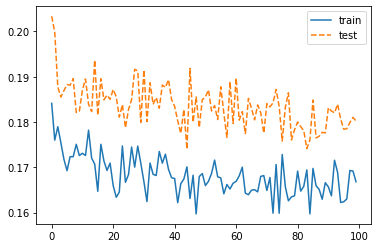

In [13]:
plt.plot(train_loss_AAPNN, '-', label='train')
plt.plot(test_loss_AAPNN, '--', label='test')
plt.legend()
best = np.argmin(test_loss_AAPNN)
AAPNN.load_state_dict(parameter_AAPNN)
best, test_loss_AAPNN[best]

In [ ]:
optimizer_AAPNN = torch.optim.Adam(AAPNN.parameters(), lr=0.01)
train_loader = DataLoader(train_data, batch_size=len(train_data))
train_loss_AAPNN, test_loss_AAPNN, parameter_AAPNN = tv.train_aged_pnn(AAPNN, train_loader, test_loader,
                                        m, T, M, K, M_test, K_test,
                                        optimizer_AAPNN, pnnv.LossFunction,
                                        Epoch=1000, cache=ds)

  0%|          | 0/1000 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.90161 | Loss: 0.183445901 |
| Epoch:    10 | Accuracy: 0.90577 | Loss: 0.178204432 |
| Epoch:    20 | Accuracy: 0.90430 | Loss: 0.178814441 |
| Epoch:    30 | Accuracy: 0.90256 | Loss: 0.183768108 |
| Epoch:    40 | Accuracy: 0.90473 | Loss: 0.178824112 |
| Epoch:    50 | Accuracy: 0.90402 | Loss: 0.179844007 |
| Epoch:    60 | Accuracy: 0.90234 | Loss: 0.183094442 |
| Epoch:    70 | Accuracy: 0.90095 | Loss: 0.190013885 |
| Epoch:    80 | Accuracy: 0.90418 | Loss: 0.182010472 |
| Epoch:    90 | Accuracy: 0.90279 | Loss: 0.183908939 |
| Epoch:   100 | Accuracy: 0.90579 | Loss: 0.176936567 |
| Epoch:   110 | Accuracy: 0.90560 | Loss: 0.177571177 |
| Epoch:   120 | Accuracy: 0.90556 | Loss: 0.177552253 |
| Epoch:   130 | Accuracy: 0.90635 | Loss: 0.175791070 |
| Epoch:   140 | Accuracy: 0.90576 | Loss: 0.177912205 |
| Epoch:   150 | Accuracy: 0.90360 | Loss: 0.183062285 |
| Epoch:   160 | Accuracy: 0.90074 | Loss: 0.190666005 |
| Epoch:   170 | Accuracy: 0.90

In [ ]:
plt.plot(train_loss_AAPNN, '-', label='train')
plt.plot(test_loss_AAPNN, '--', label='test')
plt.legend()
best = np.argmin(test_loss_AAPNN)
AAPNN.load_state_dict(parameter_AAPNN)
best, test_loss_AAPNN[best]

## Save Model

In [ ]:
with open(f'./result/{ds}_AAPNN.p', 'wb') as f:
    pickle.dump(AAPNN, f)